# Notebook on fine-tuning of OWL ViT

- OWL-ViT (short for Vision Transformer for Open-World Localization) 

# References
- https://huggingface.co/blog/fine-tune-vit
- https://github.com/huggingface/transformers/issues/28778
- https://github.com/bwconrad/vit-finetune
- https://medium.com/@supersjgk/fine-tuning-vision-transformer-with-hugging-face-and-pytorch-df19839d5396

In [1]:
# PyTorch
import torch
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
# For dislaying images
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
# Loading dataset
from datasets import load_dataset
# Transformers
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
# Matrix operations
import numpy as np
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Objective
- fine tuning on CIFAR-10 dataset using Vision Transformer (ViT) model
- CIFAR-10 data has only 10 output classes and images of size 3x32x32

# Data

In [2]:
trainds, testds = load_dataset("cifar10", split=["train[:5000]","test[:1000]"])
splits = trainds.train_test_split(test_size=0.1)
trainds = splits['train']
valds = splits['test']
trainds, valds, testds

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

(Dataset({
     features: ['img', 'label'],
     num_rows: 4500
 }),
 Dataset({
     features: ['img', 'label'],
     num_rows: 500
 }),
 Dataset({
     features: ['img', 'label'],
     num_rows: 1000
 }))

## Basic data exploration

In [3]:
trainds.features, trainds.num_rows, trainds[0]

({'img': Image(decode=True, id=None),
  'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)},
 4500,
 {'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  'label': 9})

In [4]:
itos = dict((k,v) for k,v in enumerate(trainds.features['label'].names))
stoi = dict((v,k) for k,v in enumerate(trainds.features['label'].names))
itos

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

# Plotting the image

truck


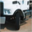

In [5]:
index = 0
img, lab = trainds[index]['img'], itos[trainds[index]['label']]
print(lab)
img

In [6]:
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name) 

mu, sigma = processor.image_mean, processor.image_std #get default mu,sigma
size = processor.size

# Image transform

In [7]:
norm = Normalize(mean=mu, std=sigma) #normalize image pixels range to [-1,1]

# resize 3x32x32 to 3x224x224 -> convert to Pytorch tensor -> normalize
_transf = Compose([
    Resize(size['height']),
    ToTensor(),
    norm
]) 

# apply transforms to PIL Image and store it to 'pixels' key
def transf(arg):
    arg['pixels'] = [_transf(image.convert('RGB')) for image in arg['img']]
    return arg

In [8]:
trainds.set_transform(transf)
valds.set_transform(transf)
testds.set_transform(transf)

# Plotting the transformed image

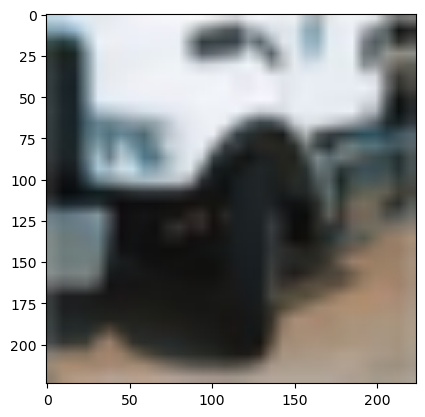

In [9]:
idx = 0
ex = trainds[idx]['pixels']
ex = (ex+1)/2 #imshow requires image pixels to be in the range [0,1]
exi = ToPILImage()(ex)
plt.imshow(exi)
plt.show()

# Original

In [10]:
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(model_name)
print(model.classifier)

Linear(in_features=768, out_features=1000, bias=True)


# Fine-tuning

In [12]:
model = ViTForImageClassification.from_pretrained(model_name, num_labels=10, ignore_mismatched_sizes=True, id2label=itos, label2id=stoi)
print(model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)


# Setup

In [13]:
args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
)

In [14]:
def collate_fn(examples):
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [15]:
trainer = Trainer(
    model,
    args, 
    train_dataset=trainds,
    eval_dataset=valds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

/home/howt/mambaforge/envs/py310cv/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [16]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key f

Epoch,Training Loss,Validation Loss


# Evaluation

In [ ]:
itos[np.argmax(outputs.predictions[0])], itos[outputs.label_ids[0]]

In [ ]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = trainds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)